In [5]:
from scipy import misc
import matplotlib.pyplot as plt
import glob
import numpy as np
import pickle
import tensorflow as tf
import os



In [6]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=""
config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )
sess = tf.Session(config=config)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())  

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9268330223959193112
]


In [7]:
with tf.device('/cpu:0'):
    # Creates a graph.
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
    # Creates a session with log_device_placement set to True.
    sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
    # Runs the op.
    print(sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]


In [8]:
pkl_file = open('crops64.pkl', 'rb')
cropspics = pickle.load(pkl_file)
pkl_file.close()

In [9]:
print(len(cropspics))
print(cropspics[0].shape)
sizes = cropspics[0].shape
#print(sizes[0])
xsize = sizes[0]
ysize = sizes[1]

500
(64, 64, 3)


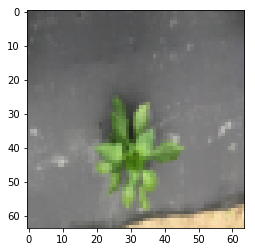

(500, 12288)
(500, 12288)


In [10]:
numofpics=len(cropspics)
allimages=np.empty(shape=[numofpics,xsize,ysize,3])
for i in range(numofpics):
	allimages[i]=cropspics[i].astype(dtype="float32")
allimages/=255
plt.imshow(allimages[4])
plt.show()
x_train = allimages.reshape((len(allimages), np.prod(allimages.shape[1:])))
x_test = allimages.reshape((len(allimages), np.prod(allimages.shape[1:])))
print(x_train.shape)
print(x_test.shape)

In [48]:
# Training Parameters
learning_rate = 0.01
num_steps = 3000
batch_size = 20

display_step = 1000
examples_to_show = 10

# Network Parameters
num_hidden_1 = 256 # 1st layer num features
num_hidden_2 = 128 # 2nd layer num features (the latent dim)
num_input = xsize*ysize #data input (img shape: 28*28)

In [49]:
with tf.device('/cpu:0'):
    # tf Graph input (only pictures)
    X = tf.placeholder("float", [None, num_input])
    weights = {
        'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
        'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
        'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
        'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
    }
    biases = {
        'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
        'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
        'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
        'decoder_b2': tf.Variable(tf.random_normal([num_input])),
    }

In [50]:
# Building the encoder
def encoder(x):
    with tf.device('/cpu:0'):
        # Encoder Hidden layer with sigmoid activation #1
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                       biases['encoder_b1']))
        # Encoder Hidden layer with sigmoid activation #2
        layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                       biases['encoder_b2']))
        return layer_2

# Building the decoder
def decoder(x):
    with tf.device('/cpu:0'):
        # Decoder Hidden layer with sigmoid activation #1
        layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                       biases['decoder_b1']))
        # Decoder Hidden layer with sigmoid activation #2
        layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                       biases['decoder_b2']))
        return layer_2

In [51]:
with tf.device('/cpu:0'):
    # Construct model
    encoder_op = encoder(X)
    decoder_op = decoder(encoder_op)

    # Prediction
    y_pred = decoder_op
    # Targets (Labels) are the input data.
    y_true = X

    # Define loss and optimizer, minimize the squared error
    loss = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
    optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()

In [41]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [34]:
# Start Training
# Start a new TF session

with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    # Training
    for i in range(1, num_steps+1):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
        batch_x, _ = mnist.train.next_batch(batch_size)
        #batch_x = x_train

        # Run optimization op (backprop) and cost op (to get loss value)
        _, l = sess.run([optimizer, loss], feed_dict={X: batch_x})
        # Display logs per step
        if i % display_step == 0 or i == 1:
            print('Step %i: Minibatch Loss: %f' % (i, l))

 

Step 1: Minibatch Loss: 0.439913
Step 1000: Minibatch Loss: 0.141567
Step 2000: Minibatch Loss: 0.122715
Step 3000: Minibatch Loss: 0.115661


In [52]:
for i in range(1, 10):
    batch_x, _ = x_train.train.next_batch(batch_size)
    print(batch_x.shape)

AttributeError: 'numpy.ndarray' object has no attribute 'train'

In [53]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

Xtr, Ytr = np.arange(0, 10), np.arange(0, 100).reshape(10, 10)
print(Xtr)
print(Ytr)

Xtr, Ytr = next_batch(5, Xtr, Ytr)
print('\n5 random samples')
print(Xtr)
print(Ytr)

[0 1 2 3 4 5 6 7 8 9]
[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]
 [30 31 32 33 34 35 36 37 38 39]
 [40 41 42 43 44 45 46 47 48 49]
 [50 51 52 53 54 55 56 57 58 59]
 [60 61 62 63 64 65 66 67 68 69]
 [70 71 72 73 74 75 76 77 78 79]
 [80 81 82 83 84 85 86 87 88 89]
 [90 91 92 93 94 95 96 97 98 99]]

5 random samples
[2 5 8 1 9]
[[20 21 22 23 24 25 26 27 28 29]
 [50 51 52 53 54 55 56 57 58 59]
 [80 81 82 83 84 85 86 87 88 89]
 [10 11 12 13 14 15 16 17 18 19]
 [90 91 92 93 94 95 96 97 98 99]]
